In [1]:
from pmdarima import auto_arima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm

In [3]:
auto_analysis_df = pd.read_excel(r'analysis.xlsx')

In [4]:
auto_analysis_df = auto_analysis_df[['Дата'
                                     , 'Количество выданных автокредитов в месяц, тыс. штук'
                                     , 'Число регистраций в месяц, тыс. штук'
                                     , 'Количество выданных автокредитов в месяц на новые автомобили, тыс. штук'
                                     , 'Число регистраций новых автомобилей в месяц, тыс. штук'
                                     , 'Количество выданных автокредитов в месяц на автомобили с пробегом, тыс. штук'
                                     , 'Число регистраций автомобилей с пробегом в месяц, тыс. штук'
                                     , 'Ключ ЦБ РФ'
                                    ]]

In [5]:
auto_analysis_df.rename(columns={'Дата': 'report_date'
                                 , 'Количество выданных автокредитов в месяц, тыс. штук' : 'auto_loan_k'
                                 , 'Число регистраций в месяц, тыс. штук' : 'auto_register_k'
                                 , 'Количество выданных автокредитов в месяц на новые автомобили, тыс. штук' : 'new_auto_loan_k'
                                 , 'Число регистраций новых автомобилей в месяц, тыс. штук' : 'new_auto_register_k'
                                 , 'Количество выданных автокредитов в месяц на автомобили с пробегом, тыс. штук' : 'old_auto_loan_k'
                                 , 'Число регистраций автомобилей с пробегом в месяц, тыс. штук' : 'old_auto_register_k'
                                 ,  'Ключ ЦБ РФ' : 'cbr_key_rate'
                                }, inplace=True)

In [6]:
auto_analysis_df = auto_analysis_df[auto_analysis_df.report_date<'2025-01-31']

In [7]:
auto_analysis_df = auto_analysis_df.set_index('report_date')

In [8]:
# x_df = auto_analysis_df['auto_loan_k']
# y_df = auto_analysis_df['auto_register_k']
# x_name = 'Количество выданных автокредитов в месяц, тыс. штук'
# y_name = 'Число регистраций в месяц, тыс. штук'



# x_df = auto_analysis_df['new_auto_loan_k']
# y_df = auto_analysis_df['new_auto_register_k']
# x_name = 'Количество выданных автокредитов в месяц на новые автомобили, тыс. штук'
# y_name = 'Число регистраций новых автомобилей в месяц, тыс. штук'



x_df = auto_analysis_df['old_auto_loan_k']
y_df = auto_analysis_df['old_auto_register_k']
x_name = 'Количество выданных автокредитов в месяц на автомобили с пробегом, тыс. штук'
y_name = 'Число регистраций автомобилей с пробегом в месяц, тыс. штук'

In [9]:
key_rate = 21

In [10]:
# define model
model = SARIMAX(x_df
                , exog = auto_analysis_df['cbr_key_rate']
                , order=(0, 1, 1)
                , seasonal_order=(0, 1, 1, 12)
               )

C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [11]:
model_fit = model.fit()

C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [12]:
#summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    old_auto_loan_k   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -132.375
Date:                            Fri, 07 Mar 2025   AIC                            272.749
Time:                                    19:24:05   BIC                            278.971
Sample:                                01-31-2021   HQIC                           274.897
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cbr_key_rate    -0.0827      1.154     -0.072      0.943      -2.345       2.180
ma.L1            0.0353      0.239      0.148      0.882      -0.432       0.503
ma.S.L12        -0.5123      0.383     -1.337      0.181      -1.263       0.239
sigma2         101.9028     26.514      3.843      0.000      49.936     153.869
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.10
Prob(Q):                              1.00   Prob(JB):                         0.05
Heteroskedasticity (H):               3.36   Skew:                            -0.62
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Forecast the next 12 steps
forecast_steps = 12

future_exog = np.ones(12)*key_rate

forecast = model_fit.get_forecast(steps=forecast_steps
                                  , exog=future_exog.reshape(-1, 1)
                                 )
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create a DataFrame for the forecast
# forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame(forecast_mean).rename(columns={'predicted_mean': 'Forecast'})

# Combine the original data and the forecast
combined_df = pd.concat([x_df, forecast_df], axis=0)

# Display the forecast
# print(forecast_df)

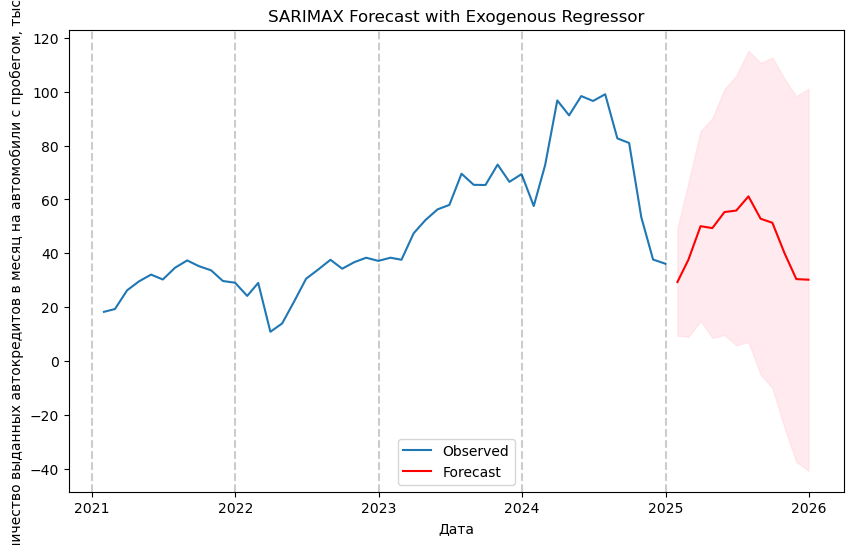

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df.index, combined_df[x_df.name], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast with Exogenous Regressor')
plt.xlabel('Дата')
plt.ylabel(x_name)
plt.legend()
for year in range(x_df.index.year.min(),x_df.index.year.max()+2):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

In [15]:
# Define the model
model = SARIMAX(y_df
                ,  exog = pd.concat([x_df, auto_analysis_df['cbr_key_rate']], axis=1)
                , order=(12, 1, 0)
                , seasonal_order=(0, 1, 1, 12)
)

# Fit the model
results = model.fit(disp=False)

# Display the summary of the model
results.summary()

C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\klyukin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                   old_auto_register_k   No. Observations:                   48
Model:             SARIMAX(12, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -170.306
Date:                               Fri, 07 Mar 2025   AIC                            372.611
Time:                                       19:24:05   BIC                            397.497
Sample:                                   01-31-2021   HQIC                           381.202
                                        - 12-31-2024                                         
Covariance Type:                                 opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
old_auto_loan_k     1.4473      0.512      2.829      0.005       0.445       2.450
cbr_key_rate        4.8717      2.169      2.246      0.025       0.621       9.123
ar.L1              -0.2716      0.421     -0.646      0.519      -1.096       0.553
ar.L2               0.6164      0.236      2.613      0.009       0.154       1.079
ar.L3              -0.1059      0.402     -0.263      0.792      -0.894       0.682
ar.L4              -0.5246      0.309     -1.700      0.089      -1.129       0.080
ar.L5              -0.0181      0.273     -0.067      0.947      -0.553       0.516
ar.L6               0.3169      0.232      1.365      0.172      -0.138       0.772
ar.L7              -0.4837      0.179     -2.700      0.007      -0.835      -0.133
ar.L8              -0.2724      0.315     -0.863      0.388      -0.891       0.346
ar.L9               0.5240      0.218      2.402      0.016       0.096       0.952
ar.L10             -0.1034      0.496     -0.209      0.835      -1.075       0.868
ar.L11             -0.5898      0.448     -1.317      0.188      -1.467       0.288
ar.L12             -0.1224      0.316     -0.387      0.699      -0.742       0.498
ma.S.L12           -0.8561      2.668     -0.321      0.748      -6.085       4.373
sigma2            505.6889   1296.278      0.390      0.696   -2034.969    3046.347
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.96   Prob(JB):                         0.58
Heteroskedasticity (H):               0.65   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# Forecast the next 12 steps
forecast_steps = 12

# Create future values for the exogenous variable
future_exog_1 = combined_df[-12:]['Forecast'].values  # Simulate future exogenous values
future_exog_2 = np.ones(12)*key_rate
future_exog = np.column_stack((future_exog_1, future_exog_2))

# Forecast
forecast = results.get_forecast(steps=forecast_steps
                                , exog=future_exog
                               )
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create a DataFrame for the forecast
# forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame(forecast_mean).rename(columns={'predicted_mean': 'Forecast'})

# Combine the original data and the forecast
combined_df = pd.concat([y_df, forecast_df], axis=0)

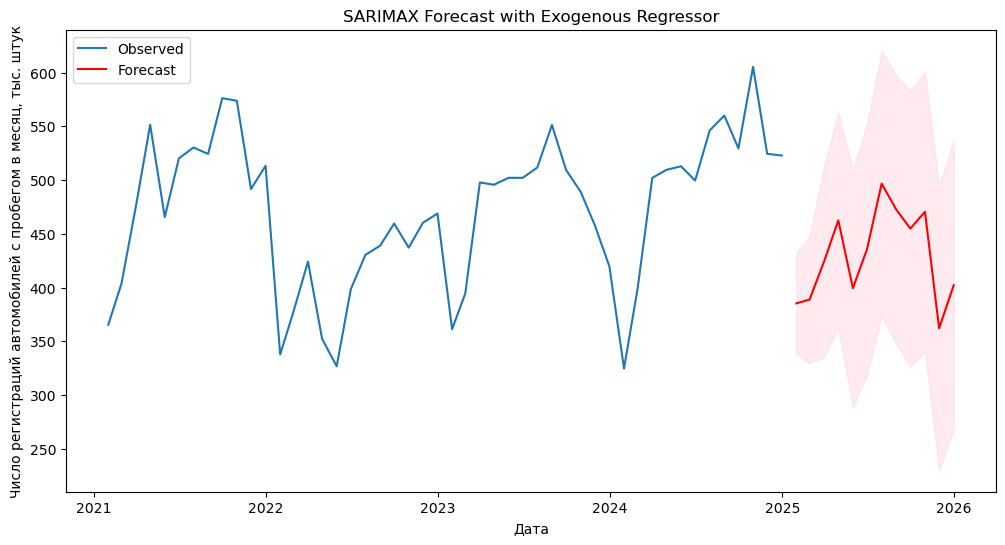

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df[y_df.name], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast with Exogenous Regressor')
plt.xlabel('Дата')
plt.ylabel(y_name)
plt.legend()
plt.show()

In [208]:
forecast_ci.to_excel(r"forecast_ci.xlsx", index=True)

In [209]:
combined_df.to_excel(r"combined_df.xlsx", index=True)

In [ ]:
import numpy as np
import pandas as pd

# Create a date range
date_range = pd.date_range(start='2020-01-01', periods=100, freq='M')

# Create a toy dataset with a seasonal component and trend
np.random.seed(42)
seasonal_component = 10 * np.sin(2 * np.pi * np.arange(100) / 12)
trend_component = 0.5 * np.arange(100)
noise = np.random.normal(0, 2, 100)

# Create an exogenous variable (e.g., advertising spend)
exog_variable = np.random.normal(10, 2, 100)  # Random values for the exogenous variable

# Combine components to create the time series
data = trend_component + seasonal_component + 0.8 * exog_variable + noise

# Create a DataFrame
df = pd.DataFrame({'Value': data, 'Exog': exog_variable}, index=date_range)

# Display the first few rows
print(df.head())

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Value'], label='Value')
plt.plot(df.index, df['Exog'], label='Exogenous Variable', linestyle='--')
plt.title('Toy Time Series Data with Exogenous Regressor')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the model
# SARIMAX(order=(p, d, q), seasonal_order=(P, D, Q, S), exog=exogenous_data)
model = SARIMAX(
    df['Value'],  # Endogenous variable (the time series to predict)
    exog=df['Exog'],  # Exogenous variable
    order=(1, 1, 2),  # Non-seasonal order (p, d, q)
    seasonal_order=(1, 1, 1, 12)  # Seasonal order (P, D, Q, S)
)

# Fit the model
results = model.fit(disp=False)

# Display the summary of the model
print(results.summary())

In [ ]:
future_exog.reshape(-1, 1)

In [ ]:
# Forecast the next 12 steps
forecast_steps = 12

# Create future values for the exogenous variable
future_exog = np.random.normal(10, 2, forecast_steps)  # Simulate future exogenous values

# Forecast
forecast = results.get_forecast(steps=forecast_steps, exog=future_exog.reshape(-1, 1))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create a DataFrame for the forecast
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame(forecast_mean).rename(columns={'predicted_mean': 'Forecast'})

# Combine the original data and the forecast
combined_df = pd.concat([df['Value'], forecast_df], axis=0)

# Display the forecast
print(forecast_df)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Value'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast with Exogenous Regressor')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()